#Libraries, Dates and Data

In [1]:
#installing libraries
!pip install yfinance
!pip install tfcausalimpact

In [2]:
#import libraries
import yfinance as yf
import pandas as pd
from causalimpact import CausalImpact
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Dates
training_start = "2014-01-08"
training_end = "2015-08-26"
treatment_start = "2015-09-02"
treatment_end = "2015-09-30"
end_stock = "2015-10-02"

In [4]:
#Download VW stock
y = ["VOW.DE"]
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = "1wk")
y = y['Adj Close'].rename("y")
y.head(1)

[*********************100%%**********************]  1 of 1 completed


Date
2014-01-06    125.62043
Name: y, dtype: float64

In [5]:
#Dowload the control groups
stocks = ["META", "DIS", "NVS", "AMZ"]
X = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1wk")
X = X.iloc[:,:len(stocks)]
X.columns = X.columns.droplevel()
X.head()

[*********************100%%**********************]  4 of 4 completed


,AMZ,DIS,META,NVS
Date,,,,
2014-01-06,290.200012,69.382645,57.939999,50.780773
2014-01-13,296.000000,68.084999,56.299999,50.680885
2014-01-20,287.000000,66.925385,54.450001,49.844326
2014-01-27,271.299988,66.824142,62.570000,49.363605
2014-02-03,260.450012,69.640312,64.320000,50.518562


In [6]:
#Combine everything
X.index = X.index.tz_localize(None)
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,AMZ,DIS,META,NVS
Date,,,,,
2014-01-06,125.620430,290.200012,69.382645,57.939999,50.780773
2014-01-13,127.199562,296.000000,68.084999,56.299999,50.680885
2014-01-20,119.239494,287.000000,66.925385,54.450001,49.844326
2014-01-27,116.242424,271.299988,66.824142,62.570000,49.363605
2014-02-03,117.628189,260.450012,69.640312,64.320000,50.518562


#Correlation Matrix

In [7]:
#Subset the training data
df_training = df[df.index <= training_end]
df_training.tail()

,y,AMZ,DIS,META,NVS
Date,,,,,
2015-07-13,136.411560,445.350006,111.423409,94.970001,70.214951
2015-07-27,123.860611,484.250000,112.492081,94.010002,68.847946
2015-08-10,121.135078,478.299988,100.455429,94.419998,68.005180
2015-08-17,111.040482,445.049988,92.655975,86.059998,64.740288
2015-08-24,114.741859,465.399994,96.068237,91.010002,65.264534


<Axes: >

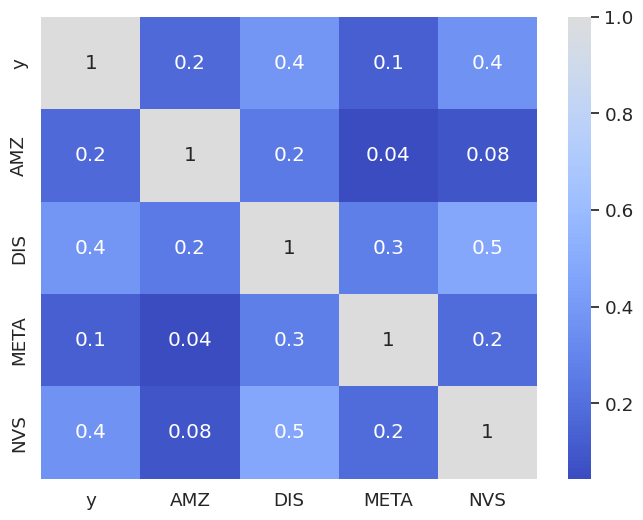

In [8]:
#Heatmap
plt.figure(figsize = (8,6))
sns.set(font_scale = 1.2)
sns.heatmap(data = df_training.pct_change().dropna().corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'coolwarm',
            center = True)

In [9]:
#Preparing final df
df_final = df.drop(columns = ["META", "AMZ"])
df_final.head(0)

,y,DIS,NVS
Date,,,


#Google Causal Impact

In [10]:
#Get first and last date
print(df_final.head(1))
print(df_final.tail(10))

                    y        DIS        NVS
Date                                       
2014-01-06  125.62043  69.382645  50.780773
                     y         DIS        NVS
Date                                         
2015-07-13  136.411560  111.423409  70.214951
2015-07-27  123.860611  112.492081  68.847946
2015-08-10  121.135078  100.455429  68.005180
2015-08-17  111.040482   92.655975  64.740288
2015-08-24  114.741859   96.068237  65.264534
2015-08-31  107.641991   94.652718  62.742870
2015-09-07  111.881706   97.943115  64.070061
2015-09-14  108.584137   96.405716  64.136421
2015-09-21   77.761993   94.024628  60.592823
2015-09-28   68.071190   96.555710  61.893467


In [11]:
#Dates
training_start = "2014-01-06"
training_end = "2015-08-31"
treatment_start = "2015-09-07"
treatment_end = "2015-09-28"
end_stock = "2015-10-02"

In [12]:
#Define Pre and Post Period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

In [13]:
#CI
impact = CausalImpact(data = df_final,
                      pre_period = pre_period,
                      post_period = post_period)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


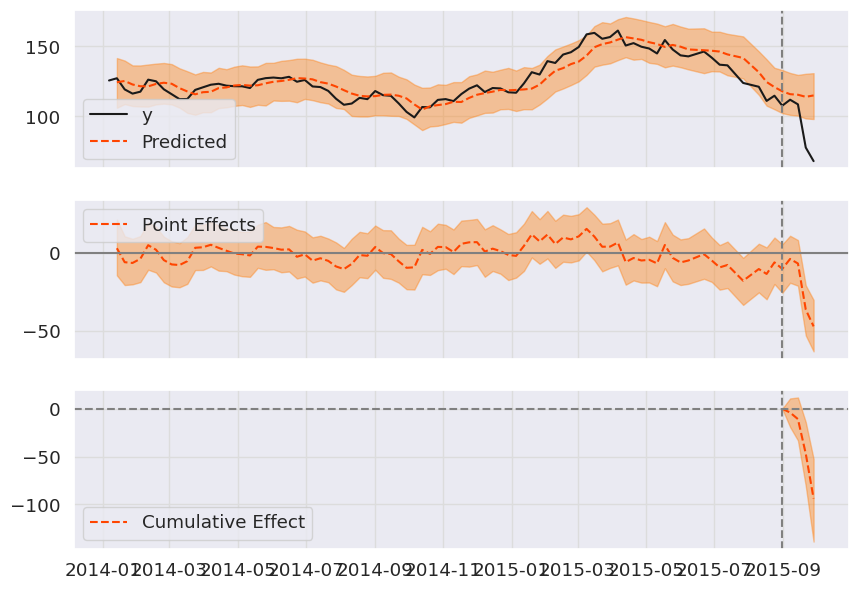

In [14]:
#Output
impact.plot()

In [15]:
#summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.57              366.3
Prediction (s.d.)         115.04 (5.76)      460.18 (23.05)
95% CI                    [103.32, 125.91]   [413.26, 503.63]

Absolute effect (s.d.)    -23.47 (5.76)      -93.88 (23.05)
95% CI                    [-34.33, -11.74]   [-137.33, -46.96]

Relative effect (s.d.)    -20.4% (5.01%)     -20.4% (5.01%)
95% CI                    [-29.84%, -10.21%] [-29.84%, -10.21%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
